#  Erdos-Renyi SC Generators Test - Version 2

- The RSC model described in [Iacopini et al., "Simplicial models of social contagion," arXiv:1810.07031v5]((https://arxiv.org/pdf/1810.07031))

- Adapted from [utils_simplagion_on_RSC.py](https://github.com/iaciac/simplagion/blob/master/utils_simplagion_on_RSC.py)

Random Simplicial Complex (RSC) model (for D=2):

- Create 1-simplices as $G(n, p_1)$
- Independently, create 2-simplices, by connecting any $i, j, k$ with probability $p_2$

Note: this independent generation means we can have both empty and filled-in triangles.

In [ ]:
import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from higher_order_structures import EmptyHypergraph

import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.stats import zipf # for power-law Zeta distribution
from itertools import combinations
from scipy.special import comb

from collections import Counter # for counting degrees

## E-R SC Version 2

In [2]:
from generators_sc import generate_my_simplicial_complex_d2, get_p1_and_p2, inter_order_overlap

In [3]:
# test ER SC version 2
N = 1000

k1_k2_list = [(3, 1), (6, 2), (10, 3), (20, 6)]
(k1, k2) = k1_k2_list[3]
print(f"Using (k1, k2) = {(k1, k2)}")

p1, p2 = get_p1_and_p2(k1,k2,N)

print(f"p1 = {p1:.4f}")
print(f"p2 = {p2:.8f}")

attempts = 1000
for _ in range(attempts):
    N_realized, edges, triangles = generate_my_simplicial_complex_d2(N,p1,p2)
    if N_realized == N:
        print(f"Found connected SC of size {N_realized}.")
        break


Using (k1, k2) = (20, 6)
p1 = 0.0081
p2 = 0.00001204
Found connected SC of size 1000.


In [4]:
g_edges = []
all_edges = edges + triangles
for edge in all_edges:
    g_edges.append(tuple(edge))
print(f"g_edges: {g_edges[:5]}, ..., {g_edges[-5:]}")

g = EmptyHypergraph(N)
g.name = "ER_SC_ver2"
g.set_edges(g_edges)
g.print()

k1_sim = np.mean([len(g.neighbors(i, 1)) for i in list(g.nodes.keys())])
k2_sim = np.mean([len(g.neighbors(i, 2)) for i in list(g.nodes.keys())])
print(f"realized k1:  {k1_sim:.2f}")
print(f"realized k2:  {k2_sim:.2f}\n")

g_edges: [(0, 227), (0, 381), (0, 533), (0, 626), (0, 694)], ..., [(866, 892, 907), (879, 922, 997), (888, 925, 931), (898, 936, 986), (903, 939, 974)]
	ER_SC_ver2 on 1000 nodes with 12593 edges.

realized k1:  20.91
realized k2:  6.42



In [5]:
inter_order_overlap(edges, triangles)

1.0

In [6]:
print(p1, np.log(N) / N)
p1 > np.log(N) / N

0.008105369807497468 0.006907755278982137


np.True_

# Check downward closure property

In this case, presence of triangle implies presence of all pairwise edges of this triangle.

In [7]:
N = 1000
max_pw_edges = comb(N, 2, exact=True) # N * (N - 1) / 2
max_ho_edges = comb(N, 3, exact=True) # N * (N - 1) * (N - 2) / 6

k1_k2_list = [(3, 1), (6, 2), (10, 3), (20, 6)]
(k1, k2) = k1_k2_list[2]

p1, p2 = get_p1_and_p2(k1,k2,N)

print(f"target p1: {p1:.4f}")
print(f"target p2: {p2:.8f}\n")
print(f"target pw edges: {p1 * max_pw_edges:.0f}/{max_pw_edges:.0f}")
print(f"target ho edges: {p2 * max_ho_edges:.0f}/{max_ho_edges:.0f}\n")

target p1: 0.0040
target p2: 0.00000602

target pw edges: 2012/499500
target ho edges: 1000/166167000



In [8]:
def check_downward_closure(edges, triangles):
    edge_set = set()
    for edge in edges:
        edge_set.add(tuple(sorted(edge)))

    is_valid_sc = True
    invalid_triangles = []

    for triangle in triangles:
        tri_sorted = sorted(triangle)
        v1, v2, v3 = tri_sorted[0], tri_sorted[1], tri_sorted[2]

        edge1 = tuple(sorted((v1, v2)))
        edge2 = tuple(sorted((v1, v3)))
        edge3 = tuple(sorted((v2, v3)))

        # check if all 3 edges are present
        if not (edge1 in edge_set and edge2 in edge_set and edge3 in edge_set):
            is_valid_sc = False
            invalid_triangles.append(list(tri_sorted))
            print(f"Invalid triangle {list(tri_sorted)}: ")
            if edge1 not in edge_set: print(f"\t Missing: {edge1}")
            if edge2 not in edge_set: print(f"\t Missing: {edge2}")
            if edge3 not in edge_set: print(f"\t Missing: {edge3}")
    return is_valid_sc

In [9]:
is_valid_sc = check_downward_closure(edges, triangles)

In [10]:
is_valid_sc

True

# Degree distribution

In [11]:
degrees_pw_instance = np.zeros(N_realized, dtype=int)
degrees_ho_instance = np.zeros(N_realized, dtype=int)

for i in range(N_realized):
    degrees_pw_instance[i] = len(g.neighbors(i, 1))
    degrees_ho_instance[i] = len(g.neighbors(i, 2))

mean_k1_realized = np.mean(degrees_pw_instance)
mean_k2_realized = np.mean(degrees_ho_instance)

print(f"realized k1:  {mean_k1_realized:.2f}")
print(f"realized k2:  {mean_k2_realized:.2f}\n")

realized k1:  20.91
realized k2:  6.42



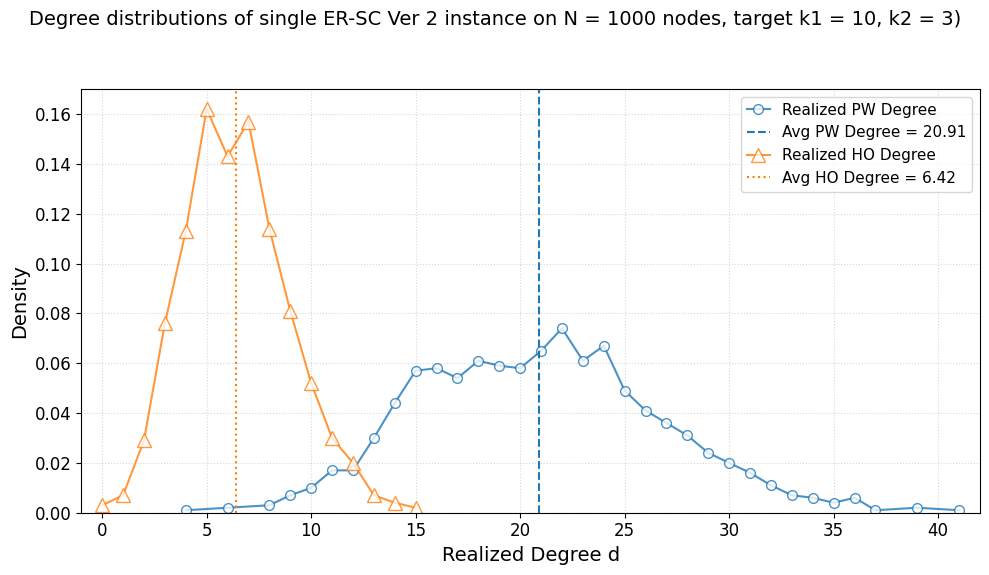

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6)) # on a single figure
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
fig.suptitle(f"Degree distributions of single ER-SC Ver 2 instance on N = {N} nodes, target k1 = {k1}, k2 = {k2})", fontsize=14)

# PW degree distribution
degree_counter_pw = Counter(degrees_pw_instance)
k_vals_pw_plot = sorted(degree_counter_pw.keys())
norm_k1_plot = np.array([degree_counter_pw[k] for k in k_vals_pw_plot]) / float(N_realized)

ax.plot(k_vals_pw_plot, norm_k1_plot, 'o-', label=r'Realized PW Degree',
        clip_on=True, mfc='white', color=u'#1f77b4', markersize=7, alpha=0.8)
ax.axvline(mean_k1_realized, ymax=1,
            linewidth=1.5, linestyle='--', color=u'#1f77b4',
            label=f'Avg PW Degree = {mean_k1_realized:.2f}')

# HO degree distribution
degree_counter_ho = Counter(degrees_ho_instance)
k_vals_ho_plot = sorted(degree_counter_ho.keys())
norm_k2_plot = np.array([degree_counter_ho[k] for k in k_vals_ho_plot]) / float(N_realized)

# ax.plot(k_vals_ho_plot, norm_k2_plot, 'o-', label=r'Realized HO Degree',
#         clip_on=True, mfc='white', color=u'#ff7f0e', markersize=5, alpha=0.8)
ax.plot(k_vals_ho_plot, norm_k2_plot, marker='^', linestyle='-', label=r'Realized HO Degree',
        clip_on=True, mfc='white', color=u'#ff7f0e', markersize=10, alpha=0.8)

ax.axvline(mean_k2_realized, ymax=1,
            linewidth=1.5, linestyle=':', color=u'#ff7f0e',
            label=f'Avg HO Degree = {mean_k2_realized:.2f}')

# plot settings
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Realized Degree d', size=14)
ax.set_ylabel('Density', size=14)
ax.set_ylim(bottom=0)

# Determine appropriate xlim based on both distributions
max_deg_overall = 0
if len(degrees_pw_instance) > 0:
    max_deg_overall = max(max_deg_overall, np.max(degrees_pw_instance))
if len(degrees_ho_instance) > 0:
    max_deg_overall = max(max_deg_overall, np.max(degrees_ho_instance))
ax.set_xlim(left=-1, right=max_deg_overall + 1 if max_deg_overall > 0 else 10)

ax.legend(fontsize=11, loc='upper right', handlelength=1.5, frameon=True) # frameon might look better
ax.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])

plt.savefig(f"../figures/hypergraphs/degree_distributions_ER_SC_ver2.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()